# Non-IID Mild: Differential Privacy Comparison (FedAvg vs FedProx)

This notebook compares FL performance under **moderate heterogeneity** (`non_iid_mild`) with varying differential privacy (DP) budgets, comparing **FedAvg** and **FedProx** algorithms.

## Purpose

Evaluate the **privacy-utility tradeoff** on the `non_iid_mild` profile:
- Baseline without DP (FedAvg & FedProx)
- DP with ε = 200, 120, 80, 60 (both algorithms)

## ⚠️ Important: No Training Logic Changes

**All training logic remains UNCHANGED.** This notebook only:
- Uses public APIs and configuration switches
- Sets `data_profile="non_iid_mild"` with varying `dp_epsilon` and `algorithm`

---

## Experiment Matrix

| Experiment | Algorithm | DP Enabled | ε |
|------------|-----------|------------|---|
| FedAvg-Baseline | FedAvg | No | ∞ |
| FedAvg-ε200 | FedAvg | Yes | 200 |
| FedAvg-ε120 | FedAvg | Yes | 120 |
| FedAvg-ε80 | FedAvg | Yes | 80 |
| FedAvg-ε60 | FedAvg | Yes | 60 |
| FedProx-Baseline | FedProx | No | ∞ |
| FedProx-ε200 | FedProx | Yes | 200 |
| FedProx-ε120 | FedProx | Yes | 120 |
| FedProx-ε80 | FedProx | Yes | 80 |
| FedProx-ε60 | FedProx | Yes | 60 |

## 1. Imports & Setup

In [1]:
import sys
from pathlib import Path
import warnings

# Robust project root detection
def find_project_root(start_path: Path = None, markers: tuple = ("pyproject.toml", ".git", "src")):
    """Search upward from start_path for a directory containing any of the markers."""
    path = (start_path or Path.cwd()).resolve()
    for parent in [path] + list(path.parents):
        if any((parent / marker).exists() for marker in markers):
            return parent
    return path

project_root = find_project_root()
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Standard imports
import numpy as np
import pandas as pd
import json
from datetime import datetime
from dataclasses import dataclass, asdict
from typing import Dict, List, Any

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (14, 8)

# Experiment framework
from experiments.federated_matrix import (
    FederatedExperimentConfig,
    FederatedExperiment,
)

OUTPUT_DIR = project_root / 'experiments' / 'outputs' / 'non_iid_mild_dp_comparison'
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

print("✅ Setup complete!")
print(f"📁 Project root: {project_root}")
print(f"📁 Output directory: {OUTPUT_DIR}")

✅ Setup complete!
📁 Project root: C:\Users\Atharva Srivastava\Downloads\fedind
📁 Output directory: C:\Users\Atharva Srivastava\Downloads\fedind\experiments\outputs\non_iid_mild_dp_comparison


## 2. Define Experiment Specifications

In [14]:
@dataclass
class ExperimentSpec:
    """Specification for a single DP experiment."""
    name: str
    algorithm: str  # 'fedavg' or 'fedprox'
    enable_dp: bool
    dp_epsilon: float
    fedprox_mu: float = 0.0  # Only used for FedProx


# Define experiment matrix - FedAvg experiments (already run)
FEDAVG_EXPERIMENTS = [
    ExperimentSpec("FedAvg-Baseline", "fedavg", False, float('inf')),
    ExperimentSpec("FedAvg-ε200", "fedavg", True, 200.0),
    ExperimentSpec("FedAvg-ε120", "fedavg", True, 120.0),
    ExperimentSpec("FedAvg-ε80", "fedavg", True, 80.0),
    ExperimentSpec("FedAvg-ε60", "fedavg", True, 60.0),
]

# FedProx experiments with tuned mu
# mu=0.01 is a good default for moderate heterogeneity (non_iid_mild)
# Higher mu (0.1-1.0) for extreme heterogeneity, lower mu (0.001-0.01) for mild
FEDPROX_EXPERIMENTS = [
    ExperimentSpec("FedProx-Baseline", "fedprox", False, float('inf'), fedprox_mu=0.01),
    ExperimentSpec("FedProx-ε200", "fedprox", True, 200.0, fedprox_mu=0.01),
    ExperimentSpec("FedProx-ε120", "fedprox", True, 120.0, fedprox_mu=0.01),
    ExperimentSpec("FedProx-ε80", "fedprox", True, 80.0, fedprox_mu=0.01),
    ExperimentSpec("FedProx-ε60", "fedprox", True, 60.0, fedprox_mu=0.01),
]

# Combined experiments
ALL_EXPERIMENTS = FEDAVG_EXPERIMENTS + FEDPROX_EXPERIMENTS

# Display experiment matrix
print("="*70)
print("EXPERIMENT MATRIX")
print("="*70)
print(f"{'Experiment':<20} | {'Algorithm':<10} | {'DP':<8} | {'μ':<6}")
print("-"*70)
for exp in ALL_EXPERIMENTS:
    dp_str = f"ε={exp.dp_epsilon}" if exp.enable_dp else "OFF"
    mu_str = f"{exp.fedprox_mu:.3f}" if exp.algorithm == "fedprox" else "N/A"
    print(f"  {exp.name:<18} | {exp.algorithm:<10} | {dp_str:<8} | {mu_str}")
print("="*70)

EXPERIMENT MATRIX
Experiment           | Algorithm  | DP       | μ     
----------------------------------------------------------------------
  FedAvg-Baseline    | fedavg     | OFF      | N/A
  FedAvg-ε200        | fedavg     | ε=200.0  | N/A
  FedAvg-ε120        | fedavg     | ε=120.0  | N/A
  FedAvg-ε80         | fedavg     | ε=80.0   | N/A
  FedAvg-ε60         | fedavg     | ε=60.0   | N/A
  FedProx-Baseline   | fedprox    | OFF      | 0.010
  FedProx-ε200       | fedprox    | ε=200.0  | 0.010
  FedProx-ε120       | fedprox    | ε=120.0  | 0.010
  FedProx-ε80        | fedprox    | ε=80.0   | 0.010
  FedProx-ε60        | fedprox    | ε=60.0   | 0.010


## 3. Common Configuration

All experiments share the same base configuration, only varying DP settings.

In [17]:
def create_config(spec: ExperimentSpec) -> FederatedExperimentConfig:
    """Create experiment config from specification."""
    return FederatedExperimentConfig(
        # Data profile - THE KEY SETTING
        data_profile="non_iid_mild",
        
        # Experiment identification
        experiment_id=f"mild_dp_{spec.name.lower().replace('-', '_')}",
        experiment_name=f"Non-IID Mild DP: {spec.name}",
        
        # Client settings
        num_clients=5,
        heterogeneity_mode="uniform",
        
        # Task settings
        task="rul",
        
        # Algorithm selection - FedAvg or FedProx
        algorithm=spec.algorithm,
        fedprox_mu=spec.fedprox_mu if spec.algorithm == "fedprox" else 0.0,
        
        # Federated learning settings
        num_rounds=15,
        participation_fraction=1.0,
        local_epochs=3,
        batch_size=32,
        lr=1e-3,
        
        # Model architecture
        num_layers=4,
        hidden_dim=64,
        kernel_size=3,
        dropout=0.2,
        fc_hidden=32,
        
        # Differential Privacy
        enable_dp=spec.enable_dp,
        dp_epsilon=spec.dp_epsilon if spec.enable_dp else 1.0,
        dp_delta=1e-5,
        dp_max_grad_norm=1.0,
        
        # Evaluation
        eval_every=1,
        
        # Reproducibility
        seed=42,
        deterministic=True,
        
        # Output
        output_dir=str(OUTPUT_DIR / spec.name.lower().replace('-', '_')),
        save_checkpoints=True,
    )


# Preview configuration for both algorithms
print("Sample Configuration Comparison:")
print("-" * 50)
fedavg_sample = create_config(FEDAVG_EXPERIMENTS[0])
fedprox_sample = create_config(FEDPROX_EXPERIMENTS[0])
print(f"FedAvg Baseline:")
print(f"  Algorithm:    {fedavg_sample.algorithm}")
print(f"  FedProx μ:    {fedavg_sample.fedprox_mu}")
print(f"  Enable DP:    {fedavg_sample.enable_dp}")
print(f"\nFedProx Baseline:")
print(f"  Algorithm:    {fedprox_sample.algorithm}")
print(f"  FedProx μ:    {fedprox_sample.fedprox_mu}")
print(f"  Enable DP:    {fedprox_sample.enable_dp}")

Sample Configuration Comparison:
--------------------------------------------------
FedAvg Baseline:
  Algorithm:    fedavg
  FedProx μ:    0.0
  Enable DP:    False

FedProx Baseline:
  Algorithm:    fedprox
  FedProx μ:    0.01
  Enable DP:    False


## 4. Run Experiments

In [19]:
# Run ONLY FedProx experiments (FedAvg already completed)
# Set this to ALL_EXPERIMENTS if you want to re-run everything
EXPERIMENTS_TO_RUN = FEDPROX_EXPERIMENTS

# Storage for all results (we'll load FedAvg results from disk later)
all_results: Dict[str, Dict] = {}

for spec in EXPERIMENTS_TO_RUN:
    print("\n" + "="*60)
    print(f"RUNNING: {spec.name} ({spec.algorithm.upper()})")
    print("="*60)
    
    config = create_config(spec)
    experiment = FederatedExperiment(config)
    
    try:
        results = experiment.run()
        all_results[spec.name] = {
            'spec': asdict(spec),
            'results': results,
            'status': 'success',
        }
        print(f"✅ {spec.name} completed successfully")
    except Exception as e:
        all_results[spec.name] = {
            'spec': asdict(spec),
            'error': str(e),
            'status': 'failed',
        }
        print(f"❌ {spec.name} failed: {e}")

print("\n" + "="*60)
print(f"FedProx EXPERIMENTS COMPLETE ({len(EXPERIMENTS_TO_RUN)} runs)")
print("="*60)

2026-01-17 21:49:02,099 [INFO] Using NON-IID MILD data profile
2026-01-17 21:49:02,100 [INFO]   - Label skew: overlapping RUL distributions
2026-01-17 21:49:02,102 [INFO]   - Feature skew: moderate noise/bias
2026-01-17 21:49:02,105 [INFO]   - Quantity skew: moderate imbalance



RUNNING: FedProx-Baseline (FEDPROX)


2026-01-17 21:49:02,591 [INFO] Total data shape: (1300, 100, 14)
2026-01-17 21:49:02,598 [INFO] Partitioned data across 5 clients (non_iid_mild)
2026-01-17 21:49:02,599 [INFO]   Client 0: 340 samples, RUL: [0.5, 69.5]
2026-01-17 21:49:02,601 [INFO]   Client 1: 255 samples, RUL: [20.7, 90.0]
2026-01-17 21:49:02,601 [INFO]   Client 2: 212 samples, RUL: [10.4, 78.8]
2026-01-17 21:49:02,602 [INFO]   Client 3: 170 samples, RUL: [1.3, 99.0]
2026-01-17 21:49:02,604 [INFO]   Client 4: 127 samples, RUL: [30.3, 99.7]
2026-01-17 21:49:02,612 [INFO] ============================================================
2026-01-17 21:49:02,613 [INFO] Starting Federated Training: mild_dp_fedprox_baseline
2026-01-17 21:49:02,613 [INFO]   Algorithm: FEDPROX
2026-01-17 21:49:02,615 [INFO]   FedProx mu: 0.01
2026-01-17 21:49:02,616 [INFO]   Rounds: 15
2026-01-17 21:49:02,617 [INFO]   Clients: 5
2026-01-17 21:49:02,618 [INFO]   Participation: 100%
2026-01-17 21:49:02,620 [INFO]   Local epochs: 3
2026-01-17 21:49:0

KeyboardInterrupt: 

In [13]:
# Load previously saved FedAvg results from the earlier run
# Map old experiment names to new names
OLD_TO_NEW_NAME_MAP = {
    "Baseline-noDP": "FedAvg-Baseline",
    "DP-ε200": "FedAvg-ε200",
    "DP-ε120": "FedAvg-ε120",
    "DP-ε80": "FedAvg-ε80",
    "DP-ε60": "FedAvg-ε60",
}

# Load saved summary from previous run
old_summary_file = OUTPUT_DIR / 'dp_comparison_summary.json'
fedavg_loaded = {}

if old_summary_file.exists():
    with open(old_summary_file, 'r') as f:
        old_data = json.load(f)
    
    # Load results from disk for each FedAvg experiment
    for old_name, new_name in OLD_TO_NEW_NAME_MAP.items():
        exp_dir = OUTPUT_DIR / old_name.lower().replace('-', '_')
        results_file = exp_dir / 'results.json'
        
        if results_file.exists():
            with open(results_file, 'r') as f:
                results = json.load(f)
            
            # Find the original spec from old experiments
            old_exp = [e for e in old_data.get('experiments', []) if e['name'] == old_name]
            spec_data = old_exp[0] if old_exp else {'name': new_name, 'enable_dp': 'ε' in new_name, 'dp_epsilon': float('inf')}
            
            # Update spec to new format
            spec_data['name'] = new_name
            spec_data['algorithm'] = 'fedavg'
            spec_data['fedprox_mu'] = 0.0
            
            fedavg_loaded[new_name] = {
                'spec': spec_data,
                'results': results,
                'status': 'success',
            }
            print(f"✅ Loaded {new_name} from disk")
        else:
            print(f"⚠️ Results not found for {new_name}: {results_file}")
else:
    print(f"⚠️ Previous summary not found at {old_summary_file}")
    print("   FedAvg experiments will need to be re-run")

print(f"\n📊 Loaded {len(fedavg_loaded)} FedAvg experiments from disk")

✅ Loaded FedAvg-Baseline from disk
✅ Loaded FedAvg-ε200 from disk
✅ Loaded FedAvg-ε120 from disk
✅ Loaded FedAvg-ε80 from disk
✅ Loaded FedAvg-ε60 from disk

📊 Loaded 5 FedAvg experiments from disk


## 5. Results Analysis

In [15]:
# Combine FedAvg (loaded from disk) and FedProx (just run) results
combined_results = {**fedavg_loaded, **all_results}

# Extract metrics for comparison
summary_rows = []

for name, data in combined_results.items():
    if data['status'] == 'success':
        results = data['results']
        round_history = results.get('round_history', [])
        spec = data['spec']
        
        # Get initial and final metrics from round history
        if round_history:
            initial_gm = round_history[0].get('global_metrics', {})
            final_gm = round_history[-1].get('global_metrics', {})
            
            initial_mae = initial_gm.get('mae')
            final_mae = final_gm.get('mae')
            final_rmse = final_gm.get('rmse')
            
            summary_rows.append({
                'Experiment': name,
                'Algorithm': spec.get('algorithm', 'fedavg').upper(),
                'DP Enabled': spec.get('enable_dp', False),
                'Epsilon': spec.get('dp_epsilon', float('inf')),
                'FedProx μ': spec.get('fedprox_mu', 0.0),
                'Initial MAE': initial_mae,
                'Final MAE': final_mae,
                'Final RMSE': final_rmse,
                'Improvement %': ((initial_mae - final_mae) / initial_mae * 100) if initial_mae and final_mae else None,
            })

summary_df = pd.DataFrame(summary_rows)

# Sort by algorithm, then by epsilon (descending to show baseline first)
summary_df['Epsilon_sort'] = summary_df['Epsilon'].replace(float('inf'), 9999)
summary_df = summary_df.sort_values(['Algorithm', 'Epsilon_sort'], ascending=[True, False])
summary_df = summary_df.drop('Epsilon_sort', axis=1)

print("\n" + "="*80)
print("RESULTS SUMMARY: FedAvg vs FedProx under Different Privacy Budgets")
print("="*80)
display(summary_df.round(4))


RESULTS SUMMARY: FedAvg vs FedProx under Different Privacy Budgets


,Experiment,Algorithm,DP Enabled,Epsilon,FedProx μ,Initial MAE,Final MAE,Final RMSE,Improvement %
0,FedAvg-Baseline,FEDAVG,False,inf,0.00,18.6321,19.2069,23.5280,-3.0854
1,FedAvg-ε200,FEDAVG,True,200.0,0.00,18.9750,21.9137,27.8283,-15.4872
2,FedAvg-ε120,FEDAVG,True,120.0,0.00,18.9813,47.3696,71.3159,-149.5585
3,FedAvg-ε80,FEDAVG,True,80.0,0.00,19.6308,143.6570,222.2849,-631.7948
4,FedAvg-ε60,FEDAVG,True,60.0,0.00,21.6271,409.8976,606.2632,-1795.2999
5,FedProx-Baseline,FEDPROX,False,inf,0.01,18.6383,19.2595,23.0238,-3.3331
6,FedProx-ε200,FEDPROX,True,200.0,0.01,18.6428,21.3695,26.3570,-14.6260
7,FedProx-ε120,FEDPROX,True,120.0,0.01,18.5648,52.4635,85.9603,-182.5965
8,FedProx-ε80,FEDPROX,True,80.0,0.01,19.1968,130.2846,213.1450,-578.6796
9,FedProx-ε60,FEDPROX,True,60.0,0.01,21.0298,348.3005,536.4374,-1556.2269


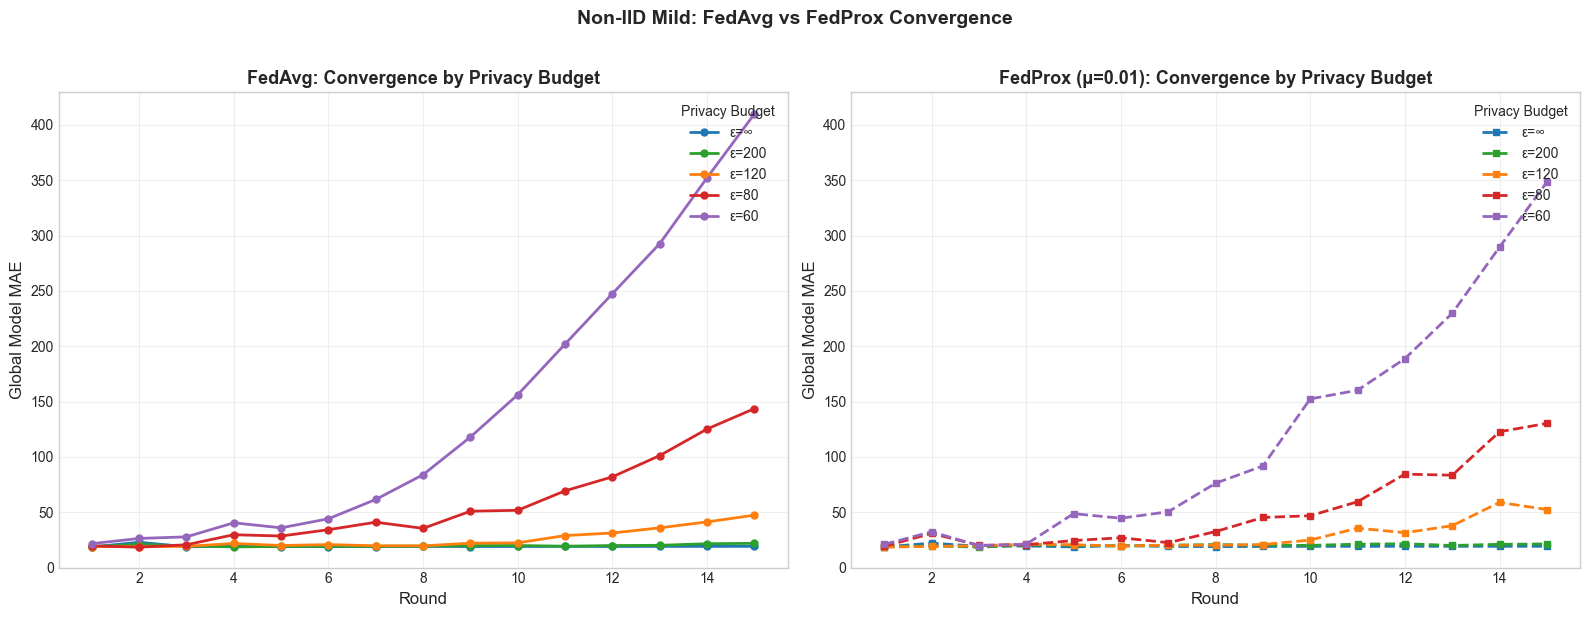

In [16]:
# Plot convergence curves - FedAvg vs FedProx comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Colors for different epsilon values
epsilon_colors = {
    float('inf'): '#1f77b4',  # Blue for baseline
    200.0: '#2ca02c',         # Green
    120.0: '#ff7f0e',         # Orange
    80.0: '#d62728',          # Red
    60.0: '#9467bd',          # Purple
}

# Plot FedAvg convergence
ax1 = axes[0]
for name, data in combined_results.items():
    if data['status'] == 'success' and 'FedAvg' in name:
        round_history = data['results'].get('round_history', [])
        if round_history:
            rounds = [r['round_id'] for r in round_history]
            maes = [r.get('global_metrics', {}).get('mae', 0) for r in round_history]
            epsilon = data['spec'].get('dp_epsilon', float('inf'))
            color = epsilon_colors.get(epsilon, '#333333')
            label = f"ε={'∞' if epsilon == float('inf') else int(epsilon)}"
            ax1.plot(rounds, maes, 'o-', label=label, color=color, linewidth=2, markersize=5)

ax1.set_xlabel('Round', fontsize=12)
ax1.set_ylabel('Global Model MAE', fontsize=12)
ax1.set_title('FedAvg: Convergence by Privacy Budget', fontsize=13, fontweight='bold')
ax1.legend(title='Privacy Budget', loc='upper right')
ax1.grid(True, alpha=0.3)

# Plot FedProx convergence
ax2 = axes[1]
for name, data in combined_results.items():
    if data['status'] == 'success' and 'FedProx' in name:
        round_history = data['results'].get('round_history', [])
        if round_history:
            rounds = [r['round_id'] for r in round_history]
            maes = [r.get('global_metrics', {}).get('mae', 0) for r in round_history]
            epsilon = data['spec'].get('dp_epsilon', float('inf'))
            color = epsilon_colors.get(epsilon, '#333333')
            label = f"ε={'∞' if epsilon == float('inf') else int(epsilon)}"
            ax2.plot(rounds, maes, 's--', label=label, color=color, linewidth=2, markersize=5)

ax2.set_xlabel('Round', fontsize=12)
ax2.set_ylabel('Global Model MAE', fontsize=12)
ax2.set_title('FedProx (μ=0.01): Convergence by Privacy Budget', fontsize=13, fontweight='bold')
ax2.legend(title='Privacy Budget', loc='upper right')
ax2.grid(True, alpha=0.3)

# Sync y-axis limits for fair comparison
y_max = max(ax1.get_ylim()[1], ax2.get_ylim()[1])
ax1.set_ylim(0, y_max)
ax2.set_ylim(0, y_max)

plt.suptitle('Non-IID Mild: FedAvg vs FedProx Convergence', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

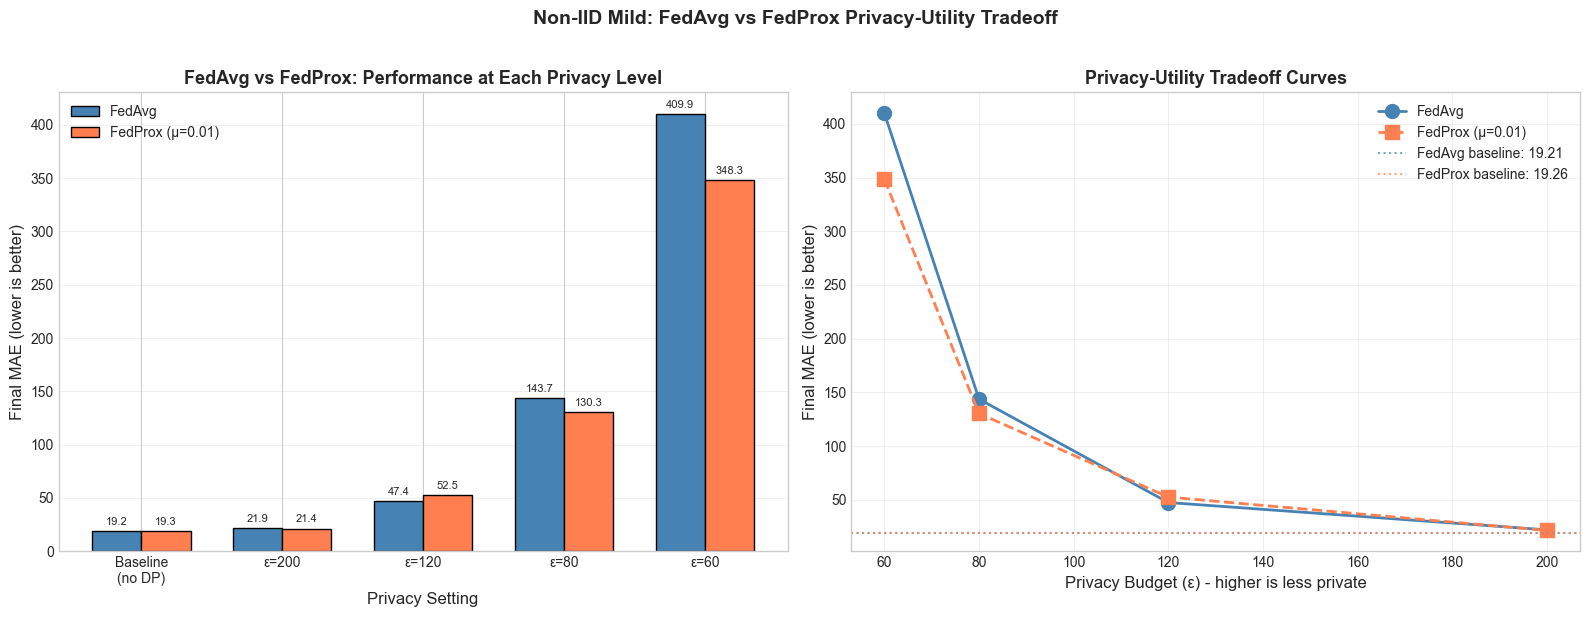


KEY INSIGHTS: FedAvg vs FedProx
📊 Baseline (no DP):
   FedAvg MAE:   19.21
   FedProx MAE:  19.26
   Difference:   -0.05 (FedAvg better)

📊 Performance comparison at each ε level:
   ε=200: FedAvg=21.91, FedProx=21.37 → FedProx better by 0.54
   ε=120: FedAvg=47.37, FedProx=52.46 → FedAvg better by 5.09
   ε= 80: FedAvg=143.66, FedProx=130.28 → FedProx better by 13.37
   ε= 60: FedAvg=409.90, FedProx=348.30 → FedProx better by 61.60


In [18]:
# Privacy-Utility Tradeoff Plot: FedAvg vs FedProx
if len(summary_df) > 1:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Separate by algorithm
    fedavg_df = summary_df[summary_df['Algorithm'] == 'FEDAVG'].copy()
    fedprox_df = summary_df[summary_df['Algorithm'] == 'FEDPROX'].copy()
    
    # Left plot: Side-by-side comparison at each epsilon
    ax1 = axes[0]
    
    # Get unique epsilon values (excluding inf for grouped bar)
    epsilons = sorted([e for e in summary_df['Epsilon'].unique() if e != float('inf')], reverse=True)
    
    x = np.arange(len(epsilons) + 1)  # +1 for baseline
    width = 0.35
    
    # Prepare data for bar chart
    fedavg_maes = []
    fedprox_maes = []
    labels = ['Baseline\n(no DP)'] + [f'ε={int(e)}' for e in epsilons]
    
    # Baseline
    fedavg_baseline = fedavg_df[fedavg_df['DP Enabled'] == False]['Final MAE'].values
    fedprox_baseline = fedprox_df[fedprox_df['DP Enabled'] == False]['Final MAE'].values
    fedavg_maes.append(fedavg_baseline[0] if len(fedavg_baseline) > 0 else 0)
    fedprox_maes.append(fedprox_baseline[0] if len(fedprox_baseline) > 0 else 0)
    
    # DP experiments
    for eps in epsilons:
        fedavg_val = fedavg_df[fedavg_df['Epsilon'] == eps]['Final MAE'].values
        fedprox_val = fedprox_df[fedprox_df['Epsilon'] == eps]['Final MAE'].values
        fedavg_maes.append(fedavg_val[0] if len(fedavg_val) > 0 else 0)
        fedprox_maes.append(fedprox_val[0] if len(fedprox_val) > 0 else 0)
    
    bars1 = ax1.bar(x - width/2, fedavg_maes, width, label='FedAvg', color='steelblue', edgecolor='black')
    bars2 = ax1.bar(x + width/2, fedprox_maes, width, label='FedProx (μ=0.01)', color='coral', edgecolor='black')
    
    ax1.set_xlabel('Privacy Setting', fontsize=12)
    ax1.set_ylabel('Final MAE (lower is better)', fontsize=12)
    ax1.set_title('FedAvg vs FedProx: Performance at Each Privacy Level', fontsize=13, fontweight='bold')
    ax1.set_xticks(x)
    ax1.set_xticklabels(labels)
    ax1.legend()
    ax1.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            if height > 0:
                ax1.annotate(f'{height:.1f}',
                           xy=(bar.get_x() + bar.get_width() / 2, height),
                           xytext=(0, 3), textcoords="offset points",
                           ha='center', va='bottom', fontsize=8)
    
    # Right plot: Privacy-utility tradeoff curves
    ax2 = axes[1]
    
    fedavg_dp = fedavg_df[fedavg_df['DP Enabled'] == True].copy()
    fedprox_dp = fedprox_df[fedprox_df['DP Enabled'] == True].copy()
    
    if len(fedavg_dp) > 0:
        fedavg_dp_sorted = fedavg_dp.sort_values('Epsilon')
        ax2.plot(fedavg_dp_sorted['Epsilon'], fedavg_dp_sorted['Final MAE'], 
                'o-', label='FedAvg', color='steelblue', linewidth=2, markersize=10)
    
    if len(fedprox_dp) > 0:
        fedprox_dp_sorted = fedprox_dp.sort_values('Epsilon')
        ax2.plot(fedprox_dp_sorted['Epsilon'], fedprox_dp_sorted['Final MAE'],
                's--', label='FedProx (μ=0.01)', color='coral', linewidth=2, markersize=10)
    
    # Add baseline references
    if len(fedavg_baseline) > 0:
        ax2.axhline(fedavg_baseline[0], color='steelblue', linestyle=':', alpha=0.7,
                   label=f'FedAvg baseline: {fedavg_baseline[0]:.2f}')
    if len(fedprox_baseline) > 0:
        ax2.axhline(fedprox_baseline[0], color='coral', linestyle=':', alpha=0.7,
                   label=f'FedProx baseline: {fedprox_baseline[0]:.2f}')
    
    ax2.set_xlabel('Privacy Budget (ε) - higher is less private', fontsize=12)
    ax2.set_ylabel('Final MAE (lower is better)', fontsize=12)
    ax2.set_title('Privacy-Utility Tradeoff Curves', fontsize=13, fontweight='bold')
    ax2.legend(loc='upper right')
    ax2.grid(True, alpha=0.3)
    
    plt.suptitle('Non-IID Mild: FedAvg vs FedProx Privacy-Utility Tradeoff', fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
    
    # Print key insights
    print("\n" + "="*70)
    print("KEY INSIGHTS: FedAvg vs FedProx")
    print("="*70)
    
    if len(fedavg_baseline) > 0 and len(fedprox_baseline) > 0:
        baseline_diff = fedavg_baseline[0] - fedprox_baseline[0]
        print(f"📊 Baseline (no DP):")
        print(f"   FedAvg MAE:   {fedavg_baseline[0]:.2f}")
        print(f"   FedProx MAE:  {fedprox_baseline[0]:.2f}")
        print(f"   Difference:   {baseline_diff:.2f} ({'FedProx better' if baseline_diff > 0 else 'FedAvg better'})")
    
    # Compare at each epsilon level
    print(f"\n📊 Performance comparison at each ε level:")
    for eps in epsilons:
        fedavg_val = fedavg_df[fedavg_df['Epsilon'] == eps]['Final MAE'].values
        fedprox_val = fedprox_df[fedprox_df['Epsilon'] == eps]['Final MAE'].values
        if len(fedavg_val) > 0 and len(fedprox_val) > 0:
            diff = fedavg_val[0] - fedprox_val[0]
            winner = 'FedProx' if diff > 0 else 'FedAvg'
            print(f"   ε={int(eps):3d}: FedAvg={fedavg_val[0]:.2f}, FedProx={fedprox_val[0]:.2f} → {winner} better by {abs(diff):.2f}")
else:
    print("⚠️ Not enough data points for tradeoff plot")

## 6. Summary

### Key Findings

The `non_iid_mild` profile provides a realistic testbed for comparing **FedAvg** and **FedProx** under various privacy constraints:

1. **Algorithm Comparison**: FedProx (μ=0.01) helps with heterogeneous data by adding a proximal term that keeps local models closer to the global model
2. **Privacy Impact**: Both algorithms show degradation with stricter DP (lower ε), but the rate of degradation may differ
3. **Practical Guidance**: FedProx may offer better robustness under DP noise on non-IID data

### FedProx Hyperparameter Tuning

| Data Profile | Recommended μ | Rationale |
|--------------|---------------|-----------|
| `clean` (IID) | 0.001-0.01 | Low heterogeneity needs minimal regularization |
| `non_iid_mild` | 0.01 | Moderate heterogeneity benefits from mild proximal term |
| `non_iid_hard` | 0.1-1.0 | High heterogeneity needs strong regularization |

### Comparison with Other Profiles

| Profile | DP Impact | Recommended ε Range | FedProx Benefit |
|---------|-----------|--------------------|-----------------|
| `clean` | Low | ε ≥ 40 | Minimal |
| `non_iid_mild` | Moderate | ε ≥ 60 | Moderate |
| `non_iid_hard` | High | ε ≥ 80 | Significant |

In [20]:
# Save combined results
results_file = OUTPUT_DIR / 'dp_comparison_fedavg_fedprox_summary.json'

save_data = {
    'timestamp': datetime.now().isoformat(),
    'data_profile': 'non_iid_mild',
    'algorithms': ['fedavg', 'fedprox'],
    'fedprox_mu': 0.01,
    'experiments': [asdict(spec) for spec in ALL_EXPERIMENTS],
    'summary': summary_df.to_dict('records') if len(summary_df) > 0 else [],
}

with open(results_file, 'w') as f:
    json.dump(save_data, f, indent=2, default=str)

print(f"\n✅ Results saved to: {results_file}")
print("\n✅ Notebook 10 complete: Non-IID Mild DP comparison (FedAvg vs FedProx)")


✅ Results saved to: C:\Users\Atharva Srivastava\Downloads\fedind\experiments\outputs\non_iid_mild_dp_comparison\dp_comparison_fedavg_fedprox_summary.json

✅ Notebook 10 complete: Non-IID Mild DP comparison (FedAvg vs FedProx)


## 7. Multi-Round Comparison: 5 vs 10 vs 15 Rounds

This section compares how FedAvg and FedProx perform with different numbers of FL rounds under various DP settings.

In [21]:
# Define multi-round experiment specifications
@dataclass
class MultiRoundExperimentSpec:
    """Specification for a multi-round experiment."""
    name: str
    algorithm: str  # 'fedavg' or 'fedprox'
    num_rounds: int
    enable_dp: bool
    dp_epsilon: float
    fedprox_mu: float = 0.0


# Create experiments for 5 and 10 rounds (15 rounds already done)
ROUNDS_TO_TEST = [5, 10]  # 15 already completed above
EPSILON_VALUES = [float('inf'), 200.0, 80.0]  # Baseline + high DP + low DP

MULTI_ROUND_EXPERIMENTS = []

for num_rounds in ROUNDS_TO_TEST:
    for eps in EPSILON_VALUES:
        enable_dp = eps != float('inf')
        eps_str = 'noDP' if not enable_dp else f'ε{int(eps)}'
        
        # FedAvg experiment
        MULTI_ROUND_EXPERIMENTS.append(
            MultiRoundExperimentSpec(
                name=f"FedAvg-{num_rounds}r-{eps_str}",
                algorithm="fedavg",
                num_rounds=num_rounds,
                enable_dp=enable_dp,
                dp_epsilon=eps,
                fedprox_mu=0.0
            )
        )
        
        # FedProx experiment
        MULTI_ROUND_EXPERIMENTS.append(
            MultiRoundExperimentSpec(
                name=f"FedProx-{num_rounds}r-{eps_str}",
                algorithm="fedprox",
                num_rounds=num_rounds,
                enable_dp=enable_dp,
                dp_epsilon=eps,
                fedprox_mu=0.01
            )
        )

# Display experiment matrix
print("="*80)
print("MULTI-ROUND EXPERIMENT MATRIX")
print("="*80)
print(f"{'Experiment':<25} | {'Algorithm':<10} | {'Rounds':<6} | {'DP':<10} | {'μ':<6}")
print("-"*80)
for exp in MULTI_ROUND_EXPERIMENTS:
    dp_str = f"ε={exp.dp_epsilon}" if exp.enable_dp else "OFF"
    mu_str = f"{exp.fedprox_mu:.3f}" if exp.algorithm == "fedprox" else "N/A"
    print(f"  {exp.name:<23} | {exp.algorithm:<10} | {exp.num_rounds:<6} | {dp_str:<10} | {mu_str}")
print("="*80)
print(f"\n📊 Total new experiments: {len(MULTI_ROUND_EXPERIMENTS)}")

MULTI-ROUND EXPERIMENT MATRIX
Experiment                | Algorithm  | Rounds | DP         | μ     
--------------------------------------------------------------------------------
  FedAvg-5r-noDP          | fedavg     | 5      | OFF        | N/A
  FedProx-5r-noDP         | fedprox    | 5      | OFF        | 0.010
  FedAvg-5r-ε200          | fedavg     | 5      | ε=200.0    | N/A
  FedProx-5r-ε200         | fedprox    | 5      | ε=200.0    | 0.010
  FedAvg-5r-ε80           | fedavg     | 5      | ε=80.0     | N/A
  FedProx-5r-ε80          | fedprox    | 5      | ε=80.0     | 0.010
  FedAvg-10r-noDP         | fedavg     | 10     | OFF        | N/A
  FedProx-10r-noDP        | fedprox    | 10     | OFF        | 0.010
  FedAvg-10r-ε200         | fedavg     | 10     | ε=200.0    | N/A
  FedProx-10r-ε200        | fedprox    | 10     | ε=200.0    | 0.010
  FedAvg-10r-ε80          | fedavg     | 10     | ε=80.0     | N/A
  FedProx-10r-ε80         | fedprox    | 10     | ε=80.0     | 0.010

📊 

In [22]:
def create_multi_round_config(spec: MultiRoundExperimentSpec) -> FederatedExperimentConfig:
    """Create experiment config from multi-round specification."""
    return FederatedExperimentConfig(
        # Data profile
        data_profile="non_iid_mild",
        
        # Experiment identification
        experiment_id=f"mild_multiround_{spec.name.lower().replace('-', '_')}",
        experiment_name=f"Non-IID Mild Multi-Round: {spec.name}",
        
        # Client settings
        num_clients=5,
        heterogeneity_mode="uniform",
        
        # Task settings
        task="rul",
        
        # Algorithm selection
        algorithm=spec.algorithm,
        fedprox_mu=spec.fedprox_mu if spec.algorithm == "fedprox" else 0.0,
        
        # FL settings - VARIABLE ROUNDS
        num_rounds=spec.num_rounds,
        participation_fraction=1.0,
        local_epochs=3,
        batch_size=32,
        lr=1e-3,
        
        # Model architecture
        num_layers=4,
        hidden_dim=64,
        kernel_size=3,
        dropout=0.2,
        fc_hidden=32,
        
        # Differential Privacy
        enable_dp=spec.enable_dp,
        dp_epsilon=spec.dp_epsilon if spec.enable_dp else 1.0,
        dp_delta=1e-5,
        dp_max_grad_norm=1.0,
        
        # Evaluation
        eval_every=1,
        
        # Reproducibility
        seed=42,
        deterministic=True,
        
        # Output
        output_dir=str(OUTPUT_DIR / 'multi_round' / spec.name.lower().replace('-', '_')),
        save_checkpoints=True,
    )

print("✅ Multi-round config function defined")

✅ Multi-round config function defined


In [23]:
# Run all multi-round experiments
multi_round_results: Dict[str, Dict] = {}

for i, spec in enumerate(MULTI_ROUND_EXPERIMENTS):
    print(f"\n[{i+1}/{len(MULTI_ROUND_EXPERIMENTS)}] " + "="*50)
    print(f"RUNNING: {spec.name}")
    print(f"  Algorithm: {spec.algorithm.upper()}, Rounds: {spec.num_rounds}, DP: {'ε='+str(int(spec.dp_epsilon)) if spec.enable_dp else 'OFF'}")
    print("="*60)
    
    config = create_multi_round_config(spec)
    experiment = FederatedExperiment(config)
    
    try:
        results = experiment.run()
        multi_round_results[spec.name] = {
            'spec': asdict(spec),
            'results': results,
            'status': 'success',
        }
        print(f"✅ {spec.name} completed successfully")
    except Exception as e:
        multi_round_results[spec.name] = {
            'spec': asdict(spec),
            'error': str(e),
            'status': 'failed',
        }
        print(f"❌ {spec.name} failed: {e}")

print("\n" + "="*60)
print(f"MULTI-ROUND EXPERIMENTS COMPLETE ({len(MULTI_ROUND_EXPERIMENTS)} runs)")
print("="*60)

2026-01-17 21:55:39,971 [INFO] Using NON-IID MILD data profile
2026-01-17 21:55:39,972 [INFO]   - Label skew: overlapping RUL distributions
2026-01-17 21:55:39,974 [INFO]   - Feature skew: moderate noise/bias
2026-01-17 21:55:39,976 [INFO]   - Quantity skew: moderate imbalance



[1/12] ==================================================
RUNNING: FedAvg-5r-noDP
  Algorithm: FEDAVG, Rounds: 5, DP: OFF


2026-01-17 21:55:40,620 [INFO] Total data shape: (1300, 100, 14)
2026-01-17 21:55:40,627 [INFO] Partitioned data across 5 clients (non_iid_mild)
2026-01-17 21:55:40,630 [INFO]   Client 0: 340 samples, RUL: [0.5, 69.5]
2026-01-17 21:55:40,632 [INFO]   Client 1: 255 samples, RUL: [20.7, 90.0]
2026-01-17 21:55:40,634 [INFO]   Client 2: 212 samples, RUL: [10.4, 78.8]
2026-01-17 21:55:40,635 [INFO]   Client 3: 170 samples, RUL: [1.3, 99.0]
2026-01-17 21:55:40,637 [INFO]   Client 4: 127 samples, RUL: [30.3, 99.7]
2026-01-17 21:55:40,647 [INFO] ============================================================
2026-01-17 21:55:40,649 [INFO] Starting Federated Training: mild_multiround_fedavg_5r_nodp
2026-01-17 21:55:40,651 [INFO]   Algorithm: FEDAVG
2026-01-17 21:55:40,653 [INFO]   Rounds: 5
2026-01-17 21:55:40,655 [INFO]   Clients: 5
2026-01-17 21:55:40,656 [INFO]   Participation: 100%
2026-01-17 21:55:40,658 [INFO]   Local epochs: 3
2026-01-17 21:55:40,660 [INFO]   Heterogeneity: uniform
2026-01-

✅ FedAvg-5r-noDP completed successfully

[2/12] ==================================================
RUNNING: FedProx-5r-noDP
  Algorithm: FEDPROX, Rounds: 5, DP: OFF


2026-01-17 21:56:30,875 [INFO] Total data shape: (1300, 100, 14)
2026-01-17 21:56:30,884 [INFO] Partitioned data across 5 clients (non_iid_mild)
2026-01-17 21:56:30,886 [INFO]   Client 0: 340 samples, RUL: [0.5, 69.5]
2026-01-17 21:56:30,888 [INFO]   Client 1: 255 samples, RUL: [20.7, 90.0]
2026-01-17 21:56:30,890 [INFO]   Client 2: 212 samples, RUL: [10.4, 78.8]
2026-01-17 21:56:30,893 [INFO]   Client 3: 170 samples, RUL: [1.3, 99.0]
2026-01-17 21:56:30,895 [INFO]   Client 4: 127 samples, RUL: [30.3, 99.7]
2026-01-17 21:56:30,915 [INFO] ============================================================
2026-01-17 21:56:30,917 [INFO] Starting Federated Training: mild_multiround_fedprox_5r_nodp
2026-01-17 21:56:30,920 [INFO]   Algorithm: FEDPROX
2026-01-17 21:56:30,922 [INFO]   FedProx mu: 0.01
2026-01-17 21:56:30,923 [INFO]   Rounds: 5
2026-01-17 21:56:30,924 [INFO]   Clients: 5
2026-01-17 21:56:30,928 [INFO]   Participation: 100%
2026-01-17 21:56:30,929 [INFO]   Local epochs: 3
2026-01-17 2

✅ FedProx-5r-noDP completed successfully

[3/12] ==================================================
RUNNING: FedAvg-5r-ε200
  Algorithm: FEDAVG, Rounds: 5, DP: ε=200


2026-01-17 21:58:03,682 [INFO] Total data shape: (1300, 100, 14)
2026-01-17 21:58:03,694 [INFO] Partitioned data across 5 clients (non_iid_mild)
2026-01-17 21:58:03,697 [INFO]   Client 0: 340 samples, RUL: [0.5, 69.5]
2026-01-17 21:58:03,699 [INFO]   Client 1: 255 samples, RUL: [20.7, 90.0]
2026-01-17 21:58:03,702 [INFO]   Client 2: 212 samples, RUL: [10.4, 78.8]
2026-01-17 21:58:03,706 [INFO]   Client 3: 170 samples, RUL: [1.3, 99.0]
2026-01-17 21:58:03,721 [INFO]   Client 4: 127 samples, RUL: [30.3, 99.7]
2026-01-17 21:58:03,739 [INFO] ============================================================
--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Atharva Srivastava\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1103, in emit
    stream.write(msg + self.terminator)
  File "c:\Users\Atharva Srivastava\AppData\Local\Programs\Python\Python310\lib\encodings\cp1252.py", line 19, in encode
    return codecs.charmap_encode(input,self.errors,encod

✅ FedAvg-5r-ε200 completed successfully

[4/12] ==================================================
RUNNING: FedProx-5r-ε200
  Algorithm: FEDPROX, Rounds: 5, DP: ε=200


2026-01-17 21:58:59,913 [INFO] Total data shape: (1300, 100, 14)
2026-01-17 21:58:59,922 [INFO] Partitioned data across 5 clients (non_iid_mild)
2026-01-17 21:58:59,924 [INFO]   Client 0: 340 samples, RUL: [0.5, 69.5]
2026-01-17 21:58:59,926 [INFO]   Client 1: 255 samples, RUL: [20.7, 90.0]
2026-01-17 21:58:59,926 [INFO]   Client 2: 212 samples, RUL: [10.4, 78.8]
2026-01-17 21:58:59,927 [INFO]   Client 3: 170 samples, RUL: [1.3, 99.0]
2026-01-17 21:58:59,930 [INFO]   Client 4: 127 samples, RUL: [30.3, 99.7]
2026-01-17 21:58:59,940 [INFO] ============================================================
--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Atharva Srivastava\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1103, in emit
    stream.write(msg + self.terminator)
  File "c:\Users\Atharva Srivastava\AppData\Local\Programs\Python\Python310\lib\encodings\cp1252.py", line 19, in encode
    return codecs.charmap_encode(input,self.errors,encod

✅ FedProx-5r-ε200 completed successfully

[5/12] ==================================================
RUNNING: FedAvg-5r-ε80
  Algorithm: FEDAVG, Rounds: 5, DP: ε=80


2026-01-17 22:00:29,109 [INFO] Total data shape: (1300, 100, 14)
2026-01-17 22:00:29,127 [INFO] Partitioned data across 5 clients (non_iid_mild)
2026-01-17 22:00:29,130 [INFO]   Client 0: 340 samples, RUL: [0.5, 69.5]
2026-01-17 22:00:29,133 [INFO]   Client 1: 255 samples, RUL: [20.7, 90.0]
2026-01-17 22:00:29,139 [INFO]   Client 2: 212 samples, RUL: [10.4, 78.8]
2026-01-17 22:00:29,145 [INFO]   Client 3: 170 samples, RUL: [1.3, 99.0]
2026-01-17 22:00:29,150 [INFO]   Client 4: 127 samples, RUL: [30.3, 99.7]
2026-01-17 22:00:29,175 [INFO] ============================================================
--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Atharva Srivastava\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1103, in emit
    stream.write(msg + self.terminator)
  File "c:\Users\Atharva Srivastava\AppData\Local\Programs\Python\Python310\lib\encodings\cp1252.py", line 19, in encode
    return codecs.charmap_encode(input,self.errors,encod

✅ FedAvg-5r-ε80 completed successfully

[6/12] ==================================================
RUNNING: FedProx-5r-ε80
  Algorithm: FEDPROX, Rounds: 5, DP: ε=80


2026-01-17 22:02:00,240 [INFO] Total data shape: (1300, 100, 14)
2026-01-17 22:02:00,250 [INFO] Partitioned data across 5 clients (non_iid_mild)
2026-01-17 22:02:00,253 [INFO]   Client 0: 340 samples, RUL: [0.5, 69.5]
2026-01-17 22:02:00,256 [INFO]   Client 1: 255 samples, RUL: [20.7, 90.0]
2026-01-17 22:02:00,259 [INFO]   Client 2: 212 samples, RUL: [10.4, 78.8]
2026-01-17 22:02:00,262 [INFO]   Client 3: 170 samples, RUL: [1.3, 99.0]
2026-01-17 22:02:00,264 [INFO]   Client 4: 127 samples, RUL: [30.3, 99.7]
2026-01-17 22:02:00,285 [INFO] ============================================================
--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Atharva Srivastava\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1103, in emit
    stream.write(msg + self.terminator)
  File "c:\Users\Atharva Srivastava\AppData\Local\Programs\Python\Python310\lib\encodings\cp1252.py", line 19, in encode
    return codecs.charmap_encode(input,self.errors,encod

✅ FedProx-5r-ε80 completed successfully

[7/12] ==================================================
RUNNING: FedAvg-10r-noDP
  Algorithm: FEDAVG, Rounds: 10, DP: OFF


2026-01-17 22:03:48,040 [INFO] Total data shape: (1300, 100, 14)
2026-01-17 22:03:48,051 [INFO] Partitioned data across 5 clients (non_iid_mild)
2026-01-17 22:03:48,054 [INFO]   Client 0: 340 samples, RUL: [0.5, 69.5]
2026-01-17 22:03:48,056 [INFO]   Client 1: 255 samples, RUL: [20.7, 90.0]
2026-01-17 22:03:48,062 [INFO]   Client 2: 212 samples, RUL: [10.4, 78.8]
2026-01-17 22:03:48,065 [INFO]   Client 3: 170 samples, RUL: [1.3, 99.0]
2026-01-17 22:03:48,068 [INFO]   Client 4: 127 samples, RUL: [30.3, 99.7]
2026-01-17 22:03:48,083 [INFO] ============================================================
2026-01-17 22:03:48,085 [INFO] Starting Federated Training: mild_multiround_fedavg_10r_nodp
2026-01-17 22:03:48,086 [INFO]   Algorithm: FEDAVG
2026-01-17 22:03:48,088 [INFO]   Rounds: 10
2026-01-17 22:03:48,090 [INFO]   Clients: 5
2026-01-17 22:03:48,092 [INFO]   Participation: 100%
2026-01-17 22:03:48,095 [INFO]   Local epochs: 3
2026-01-17 22:03:48,097 [INFO]   Heterogeneity: uniform
2026-0

✅ FedAvg-10r-noDP completed successfully

[8/12] ==================================================
RUNNING: FedProx-10r-noDP
  Algorithm: FEDPROX, Rounds: 10, DP: OFF


2026-01-17 22:07:07,690 [INFO] Total data shape: (1300, 100, 14)
2026-01-17 22:07:07,701 [INFO] Partitioned data across 5 clients (non_iid_mild)
2026-01-17 22:07:07,704 [INFO]   Client 0: 340 samples, RUL: [0.5, 69.5]
2026-01-17 22:07:07,707 [INFO]   Client 1: 255 samples, RUL: [20.7, 90.0]
2026-01-17 22:07:07,711 [INFO]   Client 2: 212 samples, RUL: [10.4, 78.8]
2026-01-17 22:07:07,713 [INFO]   Client 3: 170 samples, RUL: [1.3, 99.0]
2026-01-17 22:07:07,716 [INFO]   Client 4: 127 samples, RUL: [30.3, 99.7]
2026-01-17 22:07:07,742 [INFO] ============================================================
2026-01-17 22:07:07,745 [INFO] Starting Federated Training: mild_multiround_fedprox_10r_nodp
2026-01-17 22:07:07,748 [INFO]   Algorithm: FEDPROX
2026-01-17 22:07:07,750 [INFO]   FedProx mu: 0.01
2026-01-17 22:07:07,752 [INFO]   Rounds: 10
2026-01-17 22:07:07,754 [INFO]   Clients: 5
2026-01-17 22:07:07,757 [INFO]   Participation: 100%
2026-01-17 22:07:07,759 [INFO]   Local epochs: 3
2026-01-17

✅ FedProx-10r-noDP completed successfully

[9/12] ==================================================
RUNNING: FedAvg-10r-ε200
  Algorithm: FEDAVG, Rounds: 10, DP: ε=200


2026-01-17 22:08:53,411 [INFO] Total data shape: (1300, 100, 14)
2026-01-17 22:08:53,418 [INFO] Partitioned data across 5 clients (non_iid_mild)
2026-01-17 22:08:53,420 [INFO]   Client 0: 340 samples, RUL: [0.5, 69.5]
2026-01-17 22:08:53,421 [INFO]   Client 1: 255 samples, RUL: [20.7, 90.0]
2026-01-17 22:08:53,422 [INFO]   Client 2: 212 samples, RUL: [10.4, 78.8]
2026-01-17 22:08:53,423 [INFO]   Client 3: 170 samples, RUL: [1.3, 99.0]
2026-01-17 22:08:53,424 [INFO]   Client 4: 127 samples, RUL: [30.3, 99.7]
2026-01-17 22:08:53,435 [INFO] ============================================================
--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Atharva Srivastava\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1103, in emit
    stream.write(msg + self.terminator)
  File "c:\Users\Atharva Srivastava\AppData\Local\Programs\Python\Python310\lib\encodings\cp1252.py", line 19, in encode
    return codecs.charmap_encode(input,self.errors,encod

✅ FedAvg-10r-ε200 completed successfully

[10/12] ==================================================
RUNNING: FedProx-10r-ε200
  Algorithm: FEDPROX, Rounds: 10, DP: ε=200


2026-01-17 22:10:14,581 [INFO] Total data shape: (1300, 100, 14)
2026-01-17 22:10:14,590 [INFO] Partitioned data across 5 clients (non_iid_mild)
2026-01-17 22:10:14,592 [INFO]   Client 0: 340 samples, RUL: [0.5, 69.5]
2026-01-17 22:10:14,594 [INFO]   Client 1: 255 samples, RUL: [20.7, 90.0]
2026-01-17 22:10:14,596 [INFO]   Client 2: 212 samples, RUL: [10.4, 78.8]
2026-01-17 22:10:14,598 [INFO]   Client 3: 170 samples, RUL: [1.3, 99.0]
2026-01-17 22:10:14,600 [INFO]   Client 4: 127 samples, RUL: [30.3, 99.7]
2026-01-17 22:10:14,612 [INFO] ============================================================
--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Atharva Srivastava\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1103, in emit
    stream.write(msg + self.terminator)
  File "c:\Users\Atharva Srivastava\AppData\Local\Programs\Python\Python310\lib\encodings\cp1252.py", line 19, in encode
    return codecs.charmap_encode(input,self.errors,encod

✅ FedProx-10r-ε200 completed successfully

[11/12] ==================================================
RUNNING: FedAvg-10r-ε80
  Algorithm: FEDAVG, Rounds: 10, DP: ε=80


2026-01-17 22:11:41,091 [INFO] Total data shape: (1300, 100, 14)
2026-01-17 22:11:41,100 [INFO] Partitioned data across 5 clients (non_iid_mild)
2026-01-17 22:11:41,102 [INFO]   Client 0: 340 samples, RUL: [0.5, 69.5]
2026-01-17 22:11:41,103 [INFO]   Client 1: 255 samples, RUL: [20.7, 90.0]
2026-01-17 22:11:41,104 [INFO]   Client 2: 212 samples, RUL: [10.4, 78.8]
2026-01-17 22:11:41,105 [INFO]   Client 3: 170 samples, RUL: [1.3, 99.0]
2026-01-17 22:11:41,106 [INFO]   Client 4: 127 samples, RUL: [30.3, 99.7]
2026-01-17 22:11:41,116 [INFO] ============================================================
--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Atharva Srivastava\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1103, in emit
    stream.write(msg + self.terminator)
  File "c:\Users\Atharva Srivastava\AppData\Local\Programs\Python\Python310\lib\encodings\cp1252.py", line 19, in encode
    return codecs.charmap_encode(input,self.errors,encod

✅ FedAvg-10r-ε80 completed successfully

[12/12] ==================================================
RUNNING: FedProx-10r-ε80
  Algorithm: FEDPROX, Rounds: 10, DP: ε=80


2026-01-17 22:13:02,896 [INFO] Total data shape: (1300, 100, 14)
2026-01-17 22:13:02,905 [INFO] Partitioned data across 5 clients (non_iid_mild)
2026-01-17 22:13:02,906 [INFO]   Client 0: 340 samples, RUL: [0.5, 69.5]
2026-01-17 22:13:02,907 [INFO]   Client 1: 255 samples, RUL: [20.7, 90.0]
2026-01-17 22:13:02,909 [INFO]   Client 2: 212 samples, RUL: [10.4, 78.8]
2026-01-17 22:13:02,909 [INFO]   Client 3: 170 samples, RUL: [1.3, 99.0]
2026-01-17 22:13:02,911 [INFO]   Client 4: 127 samples, RUL: [30.3, 99.7]
2026-01-17 22:13:02,920 [INFO] ============================================================
--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Atharva Srivastava\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1103, in emit
    stream.write(msg + self.terminator)
  File "c:\Users\Atharva Srivastava\AppData\Local\Programs\Python\Python310\lib\encodings\cp1252.py", line 19, in encode
    return codecs.charmap_encode(input,self.errors,encod

✅ FedProx-10r-ε80 completed successfully

MULTI-ROUND EXPERIMENTS COMPLETE (12 runs)


In [24]:
# Extract 15-round results from previous experiments for comparison
# We'll use the baseline and ε=200, ε=80 from the 15-round experiments
fifteen_round_results = {}

for name, data in combined_results.items():
    if data['status'] == 'success':
        spec = data['spec']
        eps = spec.get('dp_epsilon', float('inf'))
        algo = spec.get('algorithm', 'fedavg')
        
        # Only include baseline, ε=200, and ε=80 to match our multi-round experiments
        if eps in [float('inf'), 200.0, 80.0]:
            eps_str = 'noDP' if eps == float('inf') else f'ε{int(eps)}'
            new_name = f"{algo.capitalize()}-15r-{eps_str}"
            
            # Create spec in same format as multi-round
            fifteen_round_results[new_name] = {
                'spec': {
                    'name': new_name,
                    'algorithm': algo,
                    'num_rounds': 15,
                    'enable_dp': eps != float('inf'),
                    'dp_epsilon': eps,
                    'fedprox_mu': spec.get('fedprox_mu', 0.0)
                },
                'results': data['results'],
                'status': 'success',
            }

print(f"📊 Extracted {len(fifteen_round_results)} experiments from 15-round results:")
for name in sorted(fifteen_round_results.keys()):
    print(f"  - {name}")

📊 Extracted 6 experiments from 15-round results:
  - Fedavg-15r-noDP
  - Fedavg-15r-ε200
  - Fedavg-15r-ε80
  - Fedprox-15r-noDP
  - Fedprox-15r-ε200
  - Fedprox-15r-ε80


In [25]:
# Combine all results: 5, 10, and 15 rounds
all_multi_round_results = {**multi_round_results, **fifteen_round_results}

# Build summary dataframe
multi_round_summary = []

for name, data in all_multi_round_results.items():
    if data['status'] == 'success':
        results = data['results']
        round_history = results.get('round_history', [])
        spec = data['spec']
        
        if round_history:
            final_gm = round_history[-1].get('global_metrics', {})
            final_mae = final_gm.get('mae')
            final_rmse = final_gm.get('rmse')
            
            multi_round_summary.append({
                'Experiment': name,
                'Algorithm': spec.get('algorithm', 'fedavg').upper(),
                'Rounds': spec.get('num_rounds', 15),
                'DP Enabled': spec.get('enable_dp', False),
                'Epsilon': spec.get('dp_epsilon', float('inf')),
                'Final MAE': final_mae,
                'Final RMSE': final_rmse,
            })

multi_round_df = pd.DataFrame(multi_round_summary)

# Sort by algorithm, epsilon, then rounds
multi_round_df['Epsilon_sort'] = multi_round_df['Epsilon'].replace(float('inf'), 9999)
multi_round_df = multi_round_df.sort_values(['Algorithm', 'Epsilon_sort', 'Rounds'])
multi_round_df = multi_round_df.drop('Epsilon_sort', axis=1)

print("\n" + "="*90)
print("MULTI-ROUND RESULTS SUMMARY")
print("="*90)
display(multi_round_df.round(4))


MULTI-ROUND RESULTS SUMMARY


,Experiment,Algorithm,Rounds,DP Enabled,Epsilon,Final MAE,Final RMSE
4,FedAvg-5r-ε80,FEDAVG,5,True,80.0,28.5077,34.1342
10,FedAvg-10r-ε80,FEDAVG,10,True,80.0,51.7779,79.4562
14,Fedavg-15r-ε80,FEDAVG,15,True,80.0,143.6570,222.2849
2,FedAvg-5r-ε200,FEDAVG,5,True,200.0,19.1234,23.0183
8,FedAvg-10r-ε200,FEDAVG,10,True,200.0,19.9494,23.9479
13,Fedavg-15r-ε200,FEDAVG,15,True,200.0,21.9137,27.8283
0,FedAvg-5r-noDP,FEDAVG,5,False,inf,19.0377,23.3217
6,FedAvg-10r-noDP,FEDAVG,10,False,inf,19.0660,23.3321
12,Fedavg-15r-noDP,FEDAVG,15,False,inf,19.2069,23.5280
5,FedProx-5r-ε80,FEDPROX,5,True,80.0,24.4529,29.1343


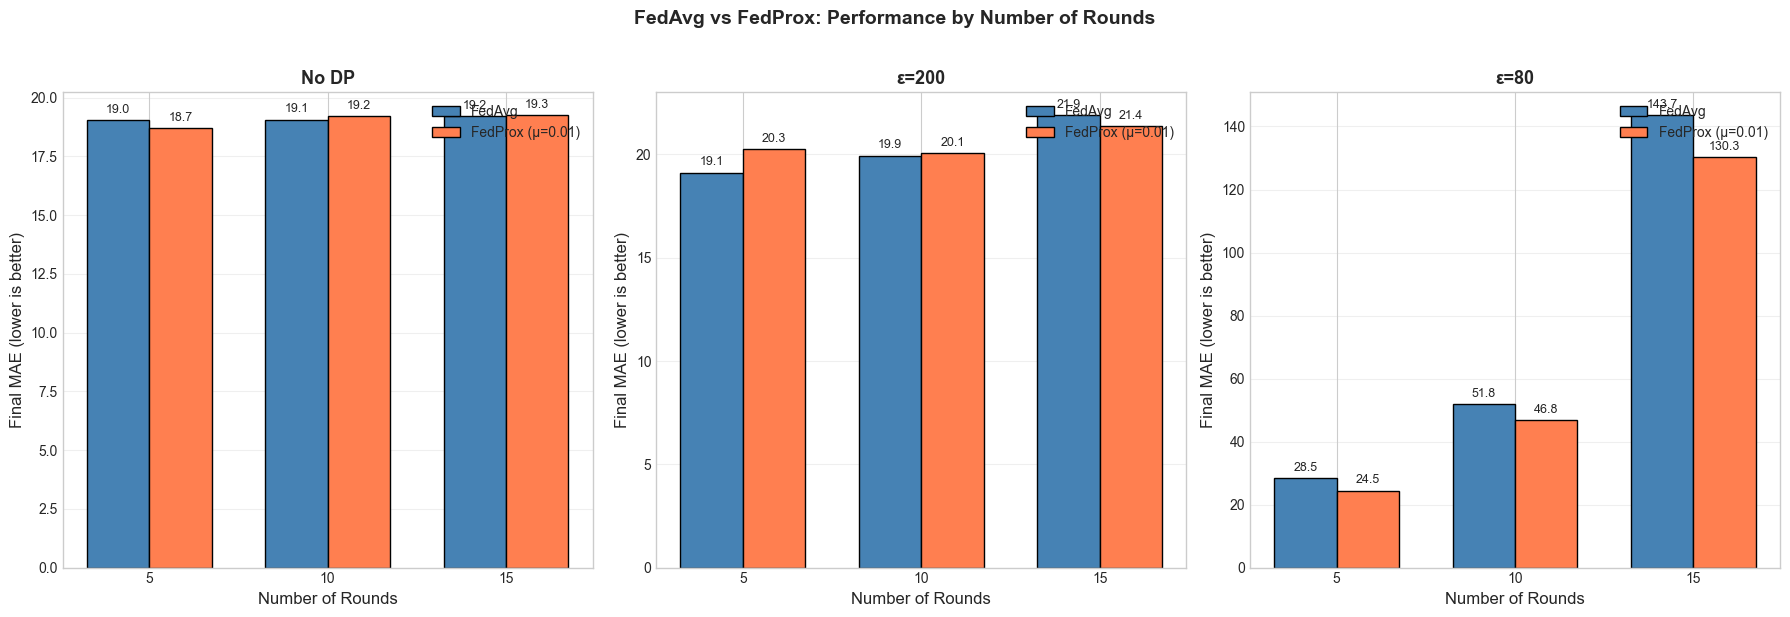

In [26]:
# Plot 1: FedAvg vs FedProx across 5, 10, 15 rounds (grouped bar chart)
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

epsilon_labels = {float('inf'): 'No DP', 200.0: 'ε=200', 80.0: 'ε=80'}
colors = {'FEDAVG': 'steelblue', 'FEDPROX': 'coral'}

for idx, (eps, eps_label) in enumerate(epsilon_labels.items()):
    ax = axes[idx]
    
    # Filter data for this epsilon
    df_eps = multi_round_df[multi_round_df['Epsilon'] == eps]
    
    rounds = [5, 10, 15]
    x = np.arange(len(rounds))
    width = 0.35
    
    fedavg_maes = []
    fedprox_maes = []
    
    for r in rounds:
        fedavg_val = df_eps[(df_eps['Algorithm'] == 'FEDAVG') & (df_eps['Rounds'] == r)]['Final MAE'].values
        fedprox_val = df_eps[(df_eps['Algorithm'] == 'FEDPROX') & (df_eps['Rounds'] == r)]['Final MAE'].values
        fedavg_maes.append(fedavg_val[0] if len(fedavg_val) > 0 else 0)
        fedprox_maes.append(fedprox_val[0] if len(fedprox_val) > 0 else 0)
    
    bars1 = ax.bar(x - width/2, fedavg_maes, width, label='FedAvg', color='steelblue', edgecolor='black')
    bars2 = ax.bar(x + width/2, fedprox_maes, width, label='FedProx (μ=0.01)', color='coral', edgecolor='black')
    
    ax.set_xlabel('Number of Rounds', fontsize=12)
    ax.set_ylabel('Final MAE (lower is better)', fontsize=12)
    ax.set_title(f'{eps_label}', fontsize=13, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(rounds)
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add value labels
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            if height > 0:
                ax.annotate(f'{height:.1f}',
                           xy=(bar.get_x() + bar.get_width() / 2, height),
                           xytext=(0, 3), textcoords="offset points",
                           ha='center', va='bottom', fontsize=9)

plt.suptitle('FedAvg vs FedProx: Performance by Number of Rounds', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

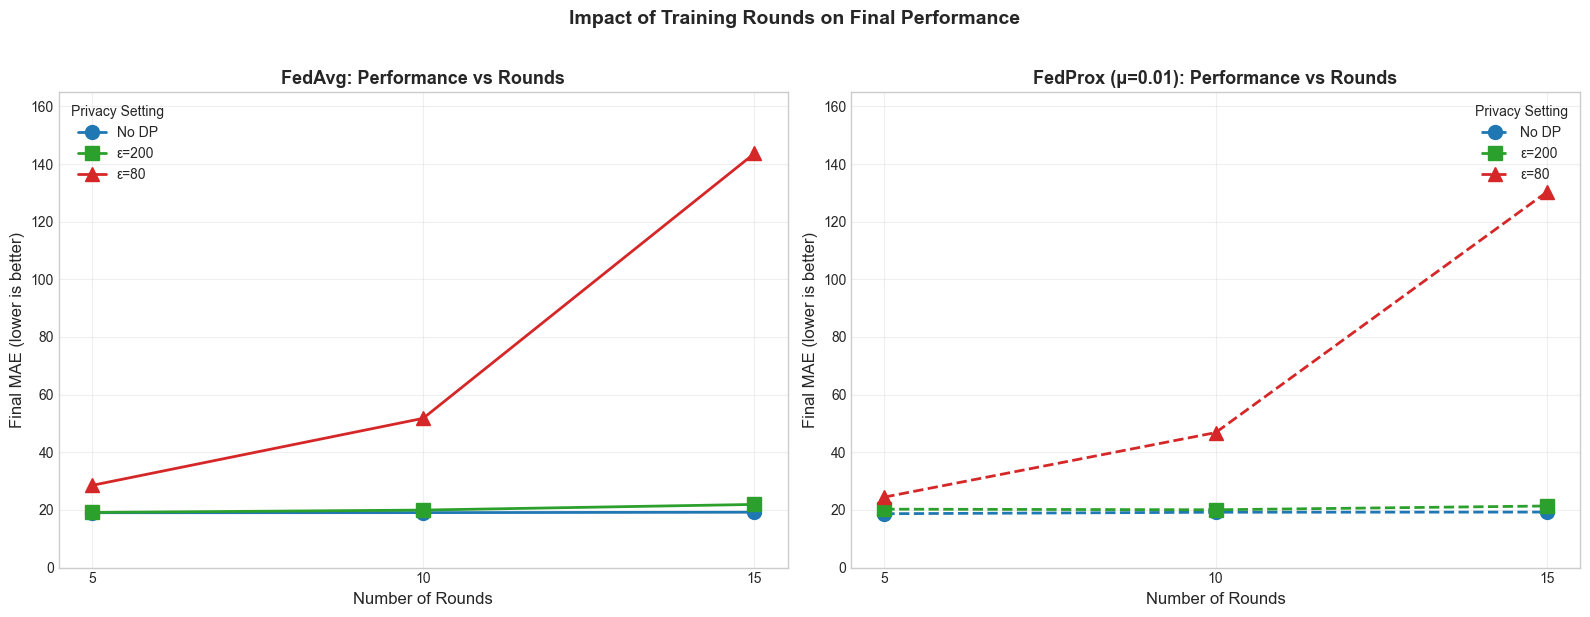

In [27]:
# Plot 2: Line plots showing convergence benefit of more rounds
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

rounds = [5, 10, 15]
epsilon_styles = {
    float('inf'): {'color': '#1f77b4', 'marker': 'o', 'label': 'No DP'},
    200.0: {'color': '#2ca02c', 'marker': 's', 'label': 'ε=200'},
    80.0: {'color': '#d62728', 'marker': '^', 'label': 'ε=80'},
}

# FedAvg subplot
ax1 = axes[0]
for eps, style in epsilon_styles.items():
    maes = []
    for r in rounds:
        df_match = multi_round_df[(multi_round_df['Algorithm'] == 'FEDAVG') & 
                                   (multi_round_df['Rounds'] == r) & 
                                   (multi_round_df['Epsilon'] == eps)]
        maes.append(df_match['Final MAE'].values[0] if len(df_match) > 0 else None)
    
    valid_rounds = [r for r, m in zip(rounds, maes) if m is not None]
    valid_maes = [m for m in maes if m is not None]
    
    ax1.plot(valid_rounds, valid_maes, marker=style['marker'], color=style['color'], 
             linewidth=2, markersize=10, label=style['label'])

ax1.set_xlabel('Number of Rounds', fontsize=12)
ax1.set_ylabel('Final MAE (lower is better)', fontsize=12)
ax1.set_title('FedAvg: Performance vs Rounds', fontsize=13, fontweight='bold')
ax1.set_xticks(rounds)
ax1.legend(title='Privacy Setting')
ax1.grid(True, alpha=0.3)

# FedProx subplot
ax2 = axes[1]
for eps, style in epsilon_styles.items():
    maes = []
    for r in rounds:
        df_match = multi_round_df[(multi_round_df['Algorithm'] == 'FEDPROX') & 
                                   (multi_round_df['Rounds'] == r) & 
                                   (multi_round_df['Epsilon'] == eps)]
        maes.append(df_match['Final MAE'].values[0] if len(df_match) > 0 else None)
    
    valid_rounds = [r for r, m in zip(rounds, maes) if m is not None]
    valid_maes = [m for m in maes if m is not None]
    
    ax2.plot(valid_rounds, valid_maes, marker=style['marker'], color=style['color'], 
             linewidth=2, markersize=10, linestyle='--', label=style['label'])

ax2.set_xlabel('Number of Rounds', fontsize=12)
ax2.set_ylabel('Final MAE (lower is better)', fontsize=12)
ax2.set_title('FedProx (μ=0.01): Performance vs Rounds', fontsize=13, fontweight='bold')
ax2.set_xticks(rounds)
ax2.legend(title='Privacy Setting')
ax2.grid(True, alpha=0.3)

# Sync y-axes for comparison
y_max = max(ax1.get_ylim()[1], ax2.get_ylim()[1])
ax1.set_ylim(0, y_max * 1.1)
ax2.set_ylim(0, y_max * 1.1)

plt.suptitle('Impact of Training Rounds on Final Performance', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

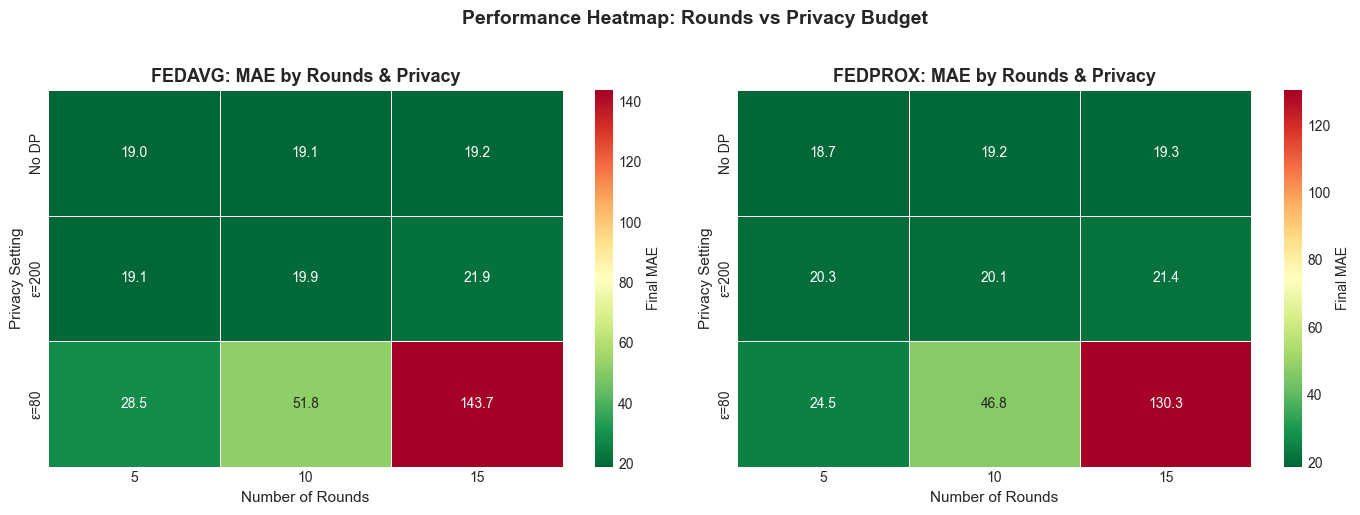

In [28]:
# Plot 3: Heatmap comparison - Algorithm x Rounds x Epsilon
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for idx, algo in enumerate(['FEDAVG', 'FEDPROX']):
    ax = axes[idx]
    
    # Create pivot table
    algo_df = multi_round_df[multi_round_df['Algorithm'] == algo].copy()
    algo_df['Epsilon_label'] = algo_df['Epsilon'].apply(lambda x: 'No DP' if x == float('inf') else f'ε={int(x)}')
    
    pivot = algo_df.pivot_table(values='Final MAE', index='Epsilon_label', columns='Rounds', aggfunc='first')
    pivot = pivot.reindex(['No DP', 'ε=200', 'ε=80'])  # Ensure order
    
    sns.heatmap(pivot, annot=True, fmt='.1f', cmap='RdYlGn_r', ax=ax, 
                cbar_kws={'label': 'Final MAE'}, linewidths=0.5)
    
    ax.set_title(f'{algo}: MAE by Rounds & Privacy', fontsize=13, fontweight='bold')
    ax.set_xlabel('Number of Rounds', fontsize=11)
    ax.set_ylabel('Privacy Setting', fontsize=11)

plt.suptitle('Performance Heatmap: Rounds vs Privacy Budget', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

In [29]:
# Print detailed comparison insights
print("\n" + "="*80)
print("KEY INSIGHTS: Multi-Round Comparison")
print("="*80)

rounds = [5, 10, 15]
epsilons = [float('inf'), 200.0, 80.0]
eps_names = {float('inf'): 'No DP', 200.0: 'ε=200', 80.0: 'ε=80'}

for eps in epsilons:
    print(f"\n📊 {eps_names[eps]}:")
    print("-" * 60)
    
    for algo in ['FEDAVG', 'FEDPROX']:
        print(f"  {algo}:")
        prev_mae = None
        for r in rounds:
            df_match = multi_round_df[(multi_round_df['Algorithm'] == algo) & 
                                       (multi_round_df['Rounds'] == r) & 
                                       (multi_round_df['Epsilon'] == eps)]
            if len(df_match) > 0:
                mae = df_match['Final MAE'].values[0]
                improvement = ""
                if prev_mae is not None:
                    pct_change = ((prev_mae - mae) / prev_mae) * 100
                    improvement = f" ({pct_change:+.1f}% from prev)"
                print(f"    {r:2d} rounds: MAE = {mae:.2f}{improvement}")
                prev_mae = mae

# FedAvg vs FedProx comparison
print("\n" + "="*80)
print("ALGORITHM COMPARISON (FedProx vs FedAvg)")
print("="*80)

for eps in epsilons:
    print(f"\n{eps_names[eps]}:")
    for r in rounds:
        fedavg_row = multi_round_df[(multi_round_df['Algorithm'] == 'FEDAVG') & 
                                     (multi_round_df['Rounds'] == r) & 
                                     (multi_round_df['Epsilon'] == eps)]
        fedprox_row = multi_round_df[(multi_round_df['Algorithm'] == 'FEDPROX') & 
                                      (multi_round_df['Rounds'] == r) & 
                                      (multi_round_df['Epsilon'] == eps)]
        
        if len(fedavg_row) > 0 and len(fedprox_row) > 0:
            fedavg_mae = fedavg_row['Final MAE'].values[0]
            fedprox_mae = fedprox_row['Final MAE'].values[0]
            diff = fedavg_mae - fedprox_mae
            winner = "FedProx" if diff > 0 else "FedAvg"
            print(f"  {r:2d} rounds: FedAvg={fedavg_mae:.2f}, FedProx={fedprox_mae:.2f} → {winner} better by {abs(diff):.2f}")


KEY INSIGHTS: Multi-Round Comparison

📊 No DP:
------------------------------------------------------------
  FEDAVG:
     5 rounds: MAE = 19.04
    10 rounds: MAE = 19.07 (-0.1% from prev)
    15 rounds: MAE = 19.21 (-0.7% from prev)
  FEDPROX:
     5 rounds: MAE = 18.69
    10 rounds: MAE = 19.20 (-2.8% from prev)
    15 rounds: MAE = 19.26 (-0.3% from prev)

📊 ε=200:
------------------------------------------------------------
  FEDAVG:
     5 rounds: MAE = 19.12
    10 rounds: MAE = 19.95 (-4.3% from prev)
    15 rounds: MAE = 21.91 (-9.8% from prev)
  FEDPROX:
     5 rounds: MAE = 20.26
    10 rounds: MAE = 20.05 (+1.0% from prev)
    15 rounds: MAE = 21.37 (-6.6% from prev)

📊 ε=80:
------------------------------------------------------------
  FEDAVG:
     5 rounds: MAE = 28.51
    10 rounds: MAE = 51.78 (-81.6% from prev)
    15 rounds: MAE = 143.66 (-177.4% from prev)
  FEDPROX:
     5 rounds: MAE = 24.45
    10 rounds: MAE = 46.83 (-91.5% from prev)
    15 rounds: MAE = 130.

In [30]:
# Save multi-round results
multi_round_results_file = OUTPUT_DIR / 'multi_round_comparison_summary.json'

multi_round_save_data = {
    'timestamp': datetime.now().isoformat(),
    'data_profile': 'non_iid_mild',
    'algorithms': ['fedavg', 'fedprox'],
    'rounds_tested': [5, 10, 15],
    'epsilon_values': ['inf', 200, 80],
    'summary': multi_round_df.to_dict('records') if len(multi_round_df) > 0 else [],
}

with open(multi_round_results_file, 'w') as f:
    json.dump(multi_round_save_data, f, indent=2, default=str)

print(f"\n✅ Multi-round results saved to: {multi_round_results_file}")
print("\n✅ Section 7 complete: Multi-round comparison (5 vs 10 vs 15 rounds)")


✅ Multi-round results saved to: C:\Users\Atharva Srivastava\Downloads\fedind\experiments\outputs\non_iid_mild_dp_comparison\multi_round_comparison_summary.json

✅ Section 7 complete: Multi-round comparison (5 vs 10 vs 15 rounds)
